In [25]:
import numpy as np
import numpy.lib.stride_tricks
import math
from matplotlib import pyplot as plt
from celluloid import Camera

In [2]:
#Custom Functions

#Trapezoid Integration Function
def integrate(u,dx,x_vals):
    area_under_curve = 0
    for i in range(0,len(x_vals)-1):
        area = dx * (u[i+1]+u[i]) / 2
        area_under_curve = area_under_curve + area
    return area_under_curve

#Gaussian Function
def gaussian(x, mu, sigma):
    denom = sigma * ((2 * math.pi)**0.5)
    numerator = math.exp(((x - mu)**2) / ((sigma) **2) / -2)
    res = numerator / denom
    return res

# Habitat Preference
def preference(x):
    pi = math.pi
    res = 0.1 + math.sin(2 * pi * x / 50) ** 2  # Example 1
    #res = math.exp(-0.01*abs(x-50)**2) # Example 2
    res = np.float64(res)
    return res

# 1st Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = (2 * pi / 25) * math.cos(pi * x / 25) * math.sin(pi * x / 25)  # Example 1
    #res = -0.02*math.exp(-0.01*(x-50)**2)*(x-50) # Example 2
    res = np.float64(res)
    return res

# 2nd Derivative of Habitat Preference Function
def preference_slope_slope(x):
    pi = math.pi
    res = (2*pi*pi/625) * math.cos(2*pi*x/25)# Example 1
    #res = -0.02 * ((-0.02 * math.exp(-0.01*(x-50)**2)*(x-50))*(x-50)+1*math.exp(-0.01*(x-50)**2)) # Example 2
    res = np.float64(res)
    return res

#Normalized RMSE

def rmse(model, true, nx, t):
    summation = 0
    for i in range(0,nx):
        dif = (model[t][1][i] - true[0][1][i])**2
        summation = summation + dif
    rmse = (summation/nx)**0.5
    return abs(rmse)

#Convergence Flag

def converge(current_t, t_minus1000, t_minus2000):
    #function to determine whether finite difference scheme has convered
    #inputs are rows of an array
    current_t = np.float128(current_t ** 0.01)
    t_minus50 = np.float128(t_minus1000 ** 0.01)
    t_minus100 = np.float128(t_minus2000 ** 0.01)
    h1 = abs(t_minus1000 - t_minus2000)
    print(h1)
    h2 = abs(current_t - t_minus1000)
    print(h2)
    dif = abs(h1-h2)
    print(dif)
    cuttoff = np.format_float_scientific(np.float128(1e-128), unique=False, precision=128)
    mask = dif>np.float128(cuttoff)
    print(mask)
    if True not in mask:
        print("yes")
        return True
        
#Sliding window
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [41]:
#Model Settings

# Bounds
start = 0 # start bound
stop = 50 # stop bound


# Model parameters
dt = 0.01 # delta t
dx = 0.05  # delta x
T = 25 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
mean_sl = 0.04 #mean step length
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

# Fourier Number Flag
if r > 0.5:
    print("Fourier Number " + str(r) +  " > 0.5. Adjust mean step length, dx, or dt")

In [42]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(start, stop + dx, dx)

# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((Nt, 2, len(Xs)))

#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])

#First Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])

#Second Spatial Derivative of Habitat Preference Function
wxx = np.zeros((1,2,len(Xs)))
wxx[0][0] = Xs
for i in range(0,len(Xs)):
    wxx[0][1][i] = preference_slope_slope(w[0][0][i])
    
# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

#Velocity
c = np.zeros((1,2,len(Xs)))
c[0][0] = Xs
for i in range(0,len(Xs)):
    c[0][1][i] = ((mean_sl**2)/dt)*(wx[0][1][i]/w[0][1][i])
    
#First derivative of veloctiy
cx = np.zeros((1,2,len(Xs)))
cx[0][0] = Xs
for i in range(0,len(Xs)):
    cx[0][1][i] = ((mean_sl**2)/dt)*(((wxx[0][1][i]*w[0][1][i])-wx[0][1][i]**2)/(w[0][1][i]**2))

# Populating x values in array u
for j in range(0, 2):
    u[j][0]=Xs

#Approximating the steady state space use

w0 = integrate(u = (w[0][1]**2),
               dx = dx,
               x_vals = Xs)
steady_state_u = np.zeros((1,2,len(Xs)))
steady_state_u[0][0] = Xs
steady_state_u[0][1] = (w[0][1]**2)/w0

# Setting Initial Condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 28,
                   sigma = 0.5) # Gaussin IC
    res = np.float64(res)
    IC.append(res)
u[0][1] = IC # Populating initial condition in array u

<function matplotlib.pyplot.show(close=None, block=None)>

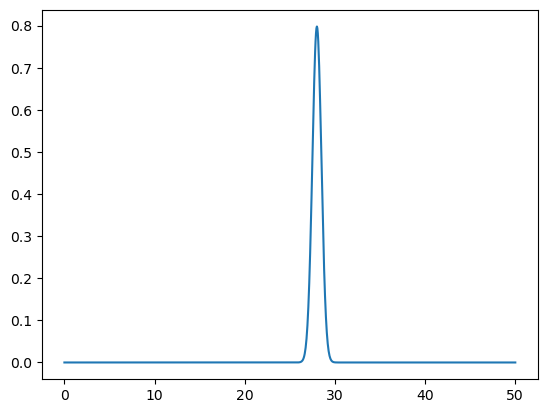

In [43]:
#Plot of Initial Condition
plt.plot(Xs, IC)
plt.show

In [44]:
#Defining where velocity is positive, negative, and 0
csign = np.where(c[0][1] < 0, -1,np.where(c[0][1]>0,1,0))

#Defining sliding windows for velocity
c_win = rolling_window(c[0][1],3)
csign_win = np.where(c_win < 0, -1,np.where(c_win>0,1,0))

##assigning advection schemes to each position X
#1 = c>0
#0 = central difference
#-1 = c<0

posc_check1 = np.all(csign_win == 1, axis = 1)
posc_check = np.append([False,False],posc_check1)

negc_check1 = np.all(csign_win == -1, axis = 1)
negc_check = np.append(negc_check1, [False,False])

cd_check = np.where(negc_check == posc_check, True, False)
cd_check[0] = False
cd_check[-1] = False

advec_scheme = np.full((1,len(Xs)),-99)
advec_scheme = np.where(posc_check == True,1,
                        np.where(negc_check == True,-1,
                                 np.where(cd_check == True, 0, advec_scheme)))

#Coefs from finite difference
advec_multipliers_cd = np.array([-1,0,1]) #central difference

advec_multipliers_posc = np.array([1,-4,3]) #upwinding c > 0

advec_multipliers_negc = np.array([-1,4,-3]) #upwinding c < 0

diffusion_multipliers = np.array([1,-2,1]) #diffusion

In [45]:
for j in range(0,Nt-1):
    
    #Sliding window for u(x,t) at time j
    u_win = rolling_window(u[j][1],3)
    a = c_win * u_win
    
    #advection calculations assuming c > 0
    advec_broad_posc = np.broadcast(a, advec_multipliers_posc)
    advec_posc = np.empty(advec_broad_posc.shape)
    advec_posc.flat = [-u*v/(2*dx) for (u,v) in advec_broad_posc]
    advec_sum_posc = np.sum(advec_posc, axis = 1)
    advec_posc = numpy.append([0,0],advec_sum_posc)
    
    #advection calculations assuming c < 0
    advec_broad_negc = np.broadcast(a, advec_multipliers_negc)
    advec_negc = np.empty(advec_broad_negc.shape)
    advec_negc.flat = [-u*v/(2*dx) for (u,v) in advec_broad_negc]
    advec_sum_negc = np.sum(advec_negc, axis = 1)
    advec_negc = numpy.append(advec_sum_negc,[0,0])
    
    #advection calculations using central difference
    advec_broad_cd = np.broadcast(a, advec_multipliers_cd)
    advec_cd = np.empty(advec_broad_cd.shape)
    advec_cd.flat = [-u*v/(2*dx) for (u,v) in advec_broad_cd]
    advec_sum_cd = np.sum(advec_cd, axis = 1)
    advec_cd1 = np.append([0], advec_sum_cd)
    advec_cd = np.append(advec_cd1,[0])
    

    advection = np.zeros((1,len(Xs)))
    advection = np.where(advec_scheme == 1, advec_posc, 
                               np.where(advec_scheme == 0, advec_cd,
                                       np.where(advec_scheme == -1, advec_negc, -99)))
    
    #Calculate Advection manually at left edge (index 0)
    backward_csign = np.array([csign[0],csign[-1], csign[-2]])
    if advection[0][0] == -99 and sum(backward_csign) == 3:
        backward_u = np.array([u[j][1][-2], u[j][1][-1], u[j],[1],[0]])
        backward_c = np.array([c[0][1][-2], c[0][1][-1]])
        advec = backward_c * advec_multipliers_posc * backward_u * (-1/(2*dx))
        advec_sum = sum(advec)
        advection[0] = advec_sum
    else:
        center_left_u = np.array([u[j][1][-1], u[j][1][0], u[j][1][1]])
        center_left_c = np.array([c[0][1][-1], c[0][1][0], c[0][1][1]])
        advec = center_left_u * center_left_c * advec_multipliers_cd * (-1/(2*dx))
        advec_sum = sum(advec)
        advection[0] = advec_sum

    #Calculating advection manually at right edge (index -1)
    forward_csign = np.array([csign[-1],csign[0], csign[1]])
    if advection[0][-1] == -99 and sum(forward_csign) == -3:
        forward_u = np.array([u[j][1][-1], u[j][1][0], u[j][1][1]])
        forward_c =  np.array([c[j][1][-1], c[j][1][0], c[j][1][1]])
        advec = forward_c * advec_multipliers_negc * forward_u * (-1/(2*dx))
        advec_sum = sum(advec)
        advection[-1] = advec_sum
    else:
        center_right_u = np.array([u[j][1][-2], u[j][1][-1], u[j][1][0]])
        center_right_c = np.array([c[0][1][-2], c[0][1][-1], c[0][1][0]])
        advec = center_left_u * center_left_c * advec_multipliers_cd * (-1/(2*dx))
        advec_sum = sum(advec)
        advection[-1] = advec_sum
    
    #Adding c'(i) * u(i,j) to advection term based on definition of d/dx[c(x) * u(x,t)]
    advection += u[j][1] * cx[0][1]
    
    #Calculating Diffusion
    dif_broad = np.broadcast(u_win,diffusion_multipliers)
    dif = np.empty(dif_broad.shape)
    dif.flat = [u*v/(2*dx) for (u,v) in dif_broad]
    dif_sum = np.sum(dif, axis = 1)
    dif1 = np.append([0], dif_sum)
    diffusion = np.append(dif1, [0])

    #Calculaing Diffusion manually at left edge (index 0)
    center_left_u = np.array([u[j][1][-1], u[j][1][0], u[j][1][1]])
    dif_left = center_left_u * diffusion_multipliers * (1/(2*dx))
    dif_left_sum = sum(dif_left)
    diffusion[0] = dif_left_sum

    #Calculating diffusion manually at right edge (index -1)
    center_right_u = np.array([u[j][1][-2], u[j][1][-1], u[j][1][0]])
    dif_right = center_right_u * diffusion_multipliers * (1/(2*dx))
    dif_right_sum = sum(dif_right)
    diffusion[0] = dif_right_sum

    #calculating u at time (j+1)
    u[j+1][1] = u[j][1] + dt * (advection + diffusion)
    area = integrate(u = u[j + 1][1],
                     dx = dx,
                     x_vals = Xs)
    u[j+1][1] = u[j+1][1]/area
    
    percent_comp = ((j+2)/(Nt))*100
    if ( percent_comp % 1 == 0):
        print(str(percent_comp)," %")
    if(percent_comp % 10 == 0):
        filename = "/Users/rhemitoth/Documents/Fall 2022/Math 19a/finalproject/RT_Math19A_Final/np_checkpoints/checkpoint{var}".format(var = str(percent_comp))
        np.save(filename, u)
        

1.0  %
2.0  %
3.0  %
4.0  %
5.0  %
6.0  %
8.0  %
9.0  %
10.0  %
11.0  %
12.0  %
13.0  %
15.0  %
16.0  %
17.0  %
18.0  %
19.0  %
20.0  %
21.0  %
22.0  %
23.0  %
24.0  %
25.0  %
26.0  %
27.0  %
30.0  %
31.0  %
32.0  %
33.0  %
34.0  %
35.0  %
36.0  %
37.0  %
38.0  %
39.0  %
40.0  %
41.0  %
42.0  %
43.0  %
44.0  %
45.0  %
46.0  %
47.0  %
48.0  %
49.0  %
50.0  %
51.0  %
52.0  %
53.0  %
54.0  %
59.0  %
60.0  %
61.0  %
62.0  %
63.0  %
64.0  %
65.0  %
66.0  %
67.0  %
68.0  %
69.0  %
70.0  %
71.0  %
72.0  %
73.0  %
74.0  %
75.0  %
76.0  %
77.0  %
78.0  %
79.0  %
80.0  %
81.0  %
82.0  %
83.0  %
84.0  %
85.0  %
86.0  %
87.0  %
88.0  %
89.0  %
90.0  %
91.0  %
92.0  %
93.0  %
94.0  %
95.0  %
96.0  %
97.0  %
98.0  %
99.0  %
100.0  %


In [46]:
#Normalized Root Mean Squared Error
error = rmse(model = u,
           true = steady_state_u,
           nx = Nx,
           t = Nt-1)

print("Root Mean Squared Error = " + str(error))

Root Mean Squared Error = 0.0702138261499924


In [47]:
#Checking for conservation

res = integrate(u = u[Nt-1][1],
              dx = dx,
              x_vals = Xs)
print(res)

0.9999999999999998


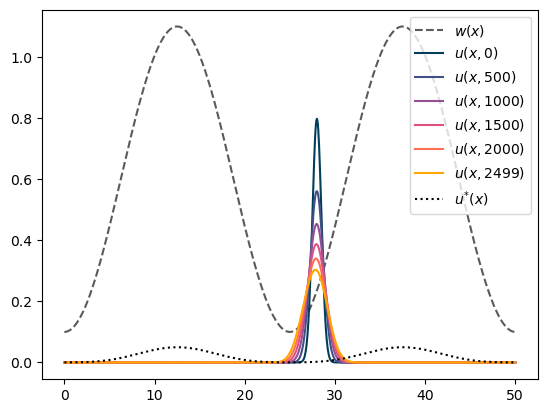

In [48]:
# Plot
fig2 = plt.figure()
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]
plt.plot(Xs,w[0][1], color = "#5a5a5a", label = r"$w(x)$", linestyle = "dashed")
plt.plot(Xs,t0, label = r'$u(x,0)$', color = "#003f5c" )
plt.plot(Xs,t1, label = fr'$u(x,{int(0.2*Nt)})$', color = "#444e86")
plt.plot(Xs,t2, label = fr'$u(x,{int(0.4*Nt)})$', color = "#955196")
plt.plot(Xs,t3, label = fr'$u(x,{int(0.6*Nt)})$', color = "#dd5182")
plt.plot(Xs,t4, label = fr'$u(x,{int(0.8*Nt)})$', color = "#ff6e54")
plt.plot(Xs,t5, label =fr'$u(x,{int(Nt-1)})$', color = "#ffa600")
plt.plot(Xs,steady_state_u[0][1], color = 'black', linestyle = 'dotted', label = r"$u^{*}(x)$")
plt.legend(loc="upper right")
plt.savefig("AdvectionDiffusion.png", dpi = 350)
plt.show()
